In [ ]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# Символьная переменная
x = sp.symbols('x')

# 1. Формирование базиса с учетом u(0)=1 и u(1)=sqrt(2)
def get_phi_functions(N):
    """
    Возвращает:
      phi0 : sympy.Expr   -- частная функция, удовлетворяющая u(0)=1, u(1)=sqrt(2)
      phis : list[sympy.Expr] -- N базисных функций, обнуляющихся при x=0 и x=1
    """
    # Линейный интерполятор между граничными значениями
    phi0 = (sp.sqrt(2) - 1)*x + 1
    # Базисные функции: phi_j(x) = x*(1-x)*x^j
    phis = [x*(1 - x)*(x**j) for j in range(1, N + 1)]
    return phi0, phis



def L_op(u_expr):
    return sp.diff(u_expr, x, 2) + sp.Rational(1, 2)*sp.diff(u_expr, x)/(x + 1) - u_expr

f_expr = -sp.sqrt(x + 1)


def gauss_legendre_quadrature(func, a, b, n=50):
    xi, wi = np.polynomial.legendre.leggauss(n)
    # Перенос узлов из [-1,1] в [a,b]
    t = 0.5*(b - a)*xi + 0.5*(b + a)
    return 0.5*(b - a) * np.dot(wi, func(t))

# 3. Сборка системы Галеркина численным интегрированием
def assemble_galerkin_numeric(phi0, phis, domain, n_quad=50):
    a, b_lim = domain
    N = len(phis)

    # Лямбдификация функций
    L_phi0_fun = sp.lambdify(x, L_op(phi0), 'numpy')
    L_phis_fun = [sp.lambdify(x, L_op(phi), 'numpy') for phi in phis]
    f_fun = sp.lambdify(x, f_expr, 'numpy')
    phis_fun = [sp.lambdify(x, phi, 'numpy') for phi in phis]

    A = np.zeros((N, N))
    b_vec = np.zeros(N)

    for i in range(N):
        phi_i = phis_fun[i]
        # A[i,j] = ∫ φ_i(x)·L(φ_j(x)) dx
        for j in range(N):
            integrand = lambda t: phi_i(t) * L_phis_fun[j](t)
            A[i, j] = gauss_legendre_quadrature(integrand, a, b_lim, n_quad)
        # b[i] = ∫ φ_i(x)·f(x) dx - ∫ φ_i(x)·L(φ0(x)) dx
        I1 = gauss_legendre_quadrature(lambda t: phi_i(t) * f_fun(t), a, b_lim, n_quad)
        I2 = gauss_legendre_quadrature(lambda t: phi_i(t) * L_phi0_fun(t), a, b_lim, n_quad)
        b_vec[i] = I1 - I2

    return A, b_vec

# 4. Решение СЛАУ и построение приближенного решения
def solve_galerkin(A, b):
    return np.linalg.solve(A, b)

def approximate_solution_fun(phi0, phis, C_vals):
    """Возвращает численную функцию u_n(x)"""
    u_sym = phi0 + sum(C_vals[i] * phis[i] for i in range(len(phis)))
    return sp.lambdify(x, u_sym, 'numpy')

# 5. Построение графика решения

def plot_solution(u_n_fun, u_exact_fun, domain):
    xs = np.linspace(domain[0], domain[1], 200)
    plt.figure()
    plt.plot(xs, u_n_fun(xs))
    plt.plot(xs, u_exact_fun(xs))
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.legend(['Galerkin approx', 'Exact'])
    plt.title('Сравнение приближенного и точного решения')
    plt.show()
    print(np.max(np.abs(u_n_fun(xs) - u_exact_fun(xs))))

# Пример использования
if __name__ == '__main__':
    domain = (0, 1)
    N = 100  # число базисных функций

    # Формируем базис
    phi0, phis = get_phi_functions(N)

    # Собираем и решаем систему
    A, b = assemble_galerkin_numeric(phi0, phis, domain, n_quad=50)
    C_vals = solve_galerkin(A, b)
    print('Коэффициенты C:', C_vals)

    # Приближенное и точное решения
    u_n = approximate_solution_fun(phi0, phis, C_vals)
    u_exact = lambda t: np.sqrt(t + 1)

    # График
    plot_solution(u_n, u_exact, domain)

Коэффициенты C: [ 0.42300321 -0.80659118  0.46032978]


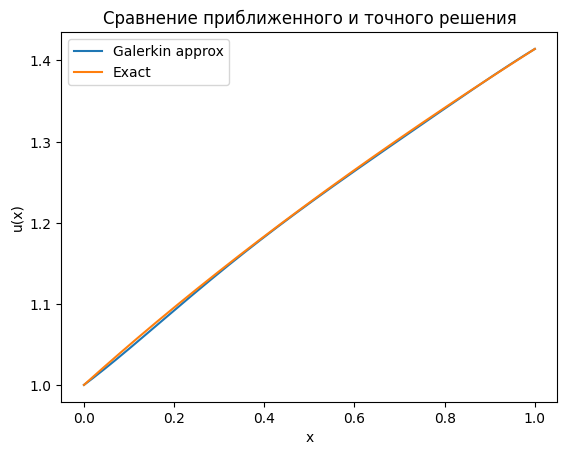

In [ ]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Символьная переменная
x = sp.symbols('x')

# 1. Формирование базиса с учетом u(0)=1 и u(1)=sqrt(2)
def get_phi_functions(N):
    """
    Возвращает:
      phi0 : sympy.Expr   -- частная функция, удовлетворяющая u(0)=1, u(1)=sqrt(2)
      phis : list[sympy.Expr] -- N базисных функций, обнуляющихся при x=0 и x=1
    """
    phi0 = (sp.sqrt(2) - 1)*x + 1
    phis = [x*(1 - x)*(x**j) for j in range(1, N + 1)]
    return phi0, phis

# Оператор L[u]
def L_op(u_expr):
    return sp.diff(u_expr, x, 2) + sp.Rational(1, 2)*sp.diff(u_expr, x)/(x + 1) - u_expr

# Правая часть f(x)
f_expr = -sp.sqrt(x + 1)

# 2. Сборка системы Галеркина с использованием scipy.integrate.quad
def assemble_galerkin_numeric(phi0, phis, domain):
    a, b_lim = domain
    N = len(phis)

    # Лямбдификация
    L_phi0_fun = sp.lambdify(x, L_op(phi0), 'numpy')
    L_phis_fun = [sp.lambdify(x, L_op(phi), 'numpy') for phi in phis]
    f_fun = sp.lambdify(x, f_expr, 'numpy')
    phis_fun = [sp.lambdify(x, phi, 'numpy') for phi in phis]

    A = np.zeros((N, N))
    b_vec = np.zeros(N)

    for i in range(N):
        phi_i = phis_fun[i]
        # A[i,j] = ∫ φ_i(x)·L(φ_j(x)) dx
        for j in range(N):
            integrand_A = lambda t: phi_i(t) * L_phis_fun[j](t)
            A[i, j] = quad(integrand_A, a, b_lim)[0]
        # b[i] = ∫ φ_i(x)·f(x) dx - ∫ φ_i(x)·L(φ0(x)) dx
        integrand_f = lambda t: phi_i(t) * f_fun(t)
        integrand_phi0 = lambda t: phi_i(t) * L_phi0_fun(t)
        I1 = quad(integrand_f, a, b_lim)[0]
        I2 = quad(integrand_phi0, a, b_lim)[0]
        b_vec[i] = I1 - I2

    return A, b_vec

# 3. Решение СЛАУ
def solve_galerkin(A, b):
    return np.linalg.solve(A, b)

# 4. Создание функции приближенного решения
def approximate_solution_fun(phi0, phis, C_vals):
    u_sym = phi0 + sum(C_vals[i] * phis[i] for i in range(len(phis)))
    return sp.lambdify(x, u_sym, 'numpy')

# 5. Построение графика решения
def plot_solution(u_n_fun, u_exact_fun, domain):
    xs = np.linspace(domain[0], domain[1], 200)
    plt.figure()
    plt.plot(xs, u_n_fun(xs))
    plt.plot(xs, u_exact_fun(xs))
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.legend(['Galerkin approx', 'Exact'])
    plt.title('Сравнение приближенного и точного решения')
    plt.show()

# Пример использования
if __name__ == '__main__':
    domain = (0, 1)
    N = 3  # число базисных функций

    phi0, phis = get_phi_functions(N)
    A, b = assemble_galerkin_numeric(phi0, phis, domain)
    C_vals = solve_galerkin(A, b)
    print('Коэффициенты C:', C_vals)

    u_n = approximate_solution_fun(phi0, phis, C_vals)
    u_exact = lambda t: np.sqrt(t + 1)
    plot_solution(u_n, u_exact, domain)
